# Kalman filter

Notebook about testing bootstrap pf and auxiliary pf on simpler model for which kalman filter exits.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [2]:
from src.models.lgm import LGModelParams, LGModel
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.auxiliary_pf import AuxiliaryParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

In [3]:
# Set random seed for reproducibility
rng = np.random.default_rng(42)

theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=1.0,
    sigma_y=0.5
)

model = LGModel(rng=rng)

In [4]:
# Generate data
T = 100

x_true, y = simulate_data(model, theta, T, rng)

In [10]:
def kalman_filter(y, theta: LGModelParams):
    T = len(y)
    mu = np.zeros(T)
    var = np.zeros(T)

    # Initial state
    mu_prev = 0.0
    var_prev = 1.0

    for t in range(T):
        # Prediction
        mu_pred = theta.a * mu_prev
        var_pred = theta.a**2 * var_prev + theta.sigma_x**2

        # Update
        K = var_pred * theta.b / (theta.b**2 * var_pred + theta.sigma_y**2)
        mu[t] = mu_pred + K * (y[t] - theta.b * mu_pred)
        var[t] = (1 - K * theta.b) * var_pred

        mu_prev = mu[t]
        var_prev = var[t]

    return mu, var

In [11]:
N = 1000

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)
apf = AuxiliaryParticleFilter(model, N, resampler=systematic_resampling)
bpf_history = bpf.run(y, theta)
apf_history = apf.run(y, theta)

In [12]:
def compute_pf_stats(history):
    means, vars_ = [], []
    for particles, weights in history:
        particles = np.array(particles)
        mean = np.sum(weights * particles)
        var = np.sum(weights * (particles - mean)**2)
        means.append(mean)
        vars_.append(var)
    return np.array(means), np.array(vars_)

In [13]:
bpf_mean, bpf_var = compute_pf_stats(bpf_history)
apf_mean, apf_var = compute_pf_stats(apf_history)
kf_mean, kf_var = kalman_filter(y, theta)

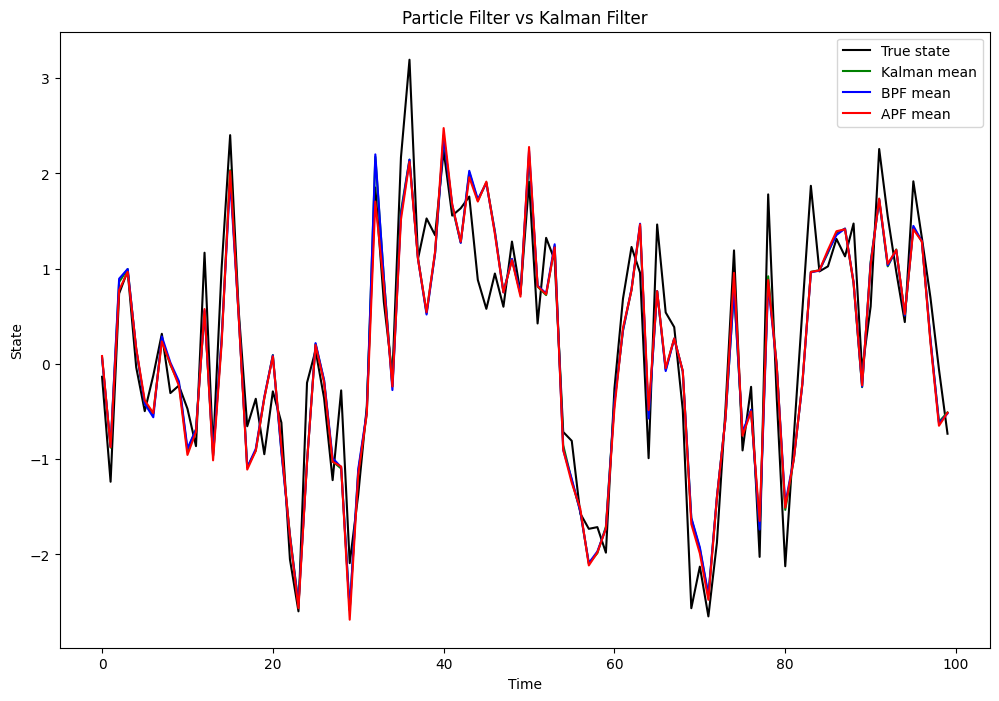

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(x_true[1:], label="True state", color='black')
plt.plot(kf_mean, label="Kalman mean", linestyle='-', color='green')
plt.plot(bpf_mean, label="BPF mean", linestyle='-', color='blue')
plt.plot(apf_mean, label="APF mean", linestyle='-', color='red')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Particle Filter vs Kalman Filter")
plt.legend()
plt.show()

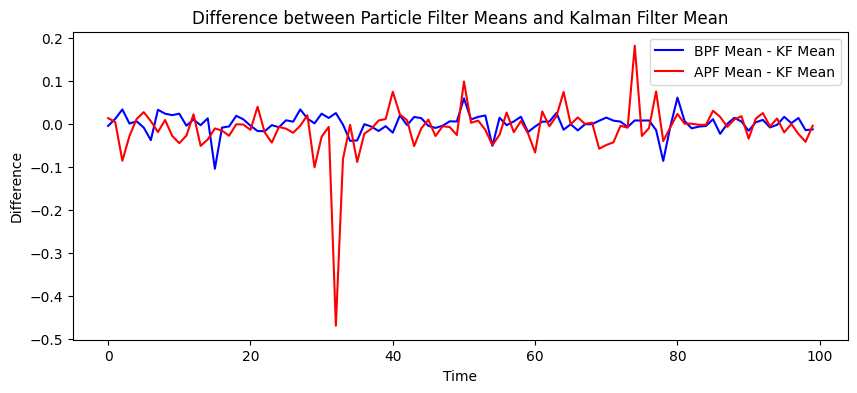

In [15]:
# Plot difference between PF means and KF mean
plt.figure(figsize=(10,4))
plt.plot(bpf_mean - kf_mean, label="BPF Mean - KF Mean", color='blue')
plt.plot(apf_mean - kf_mean, label="APF Mean - KF Mean", color='red')
plt.xlabel("Time")
plt.ylabel("Difference")
plt.title("Difference between Particle Filter Means and Kalman Filter Mean")
plt.legend()
plt.show()

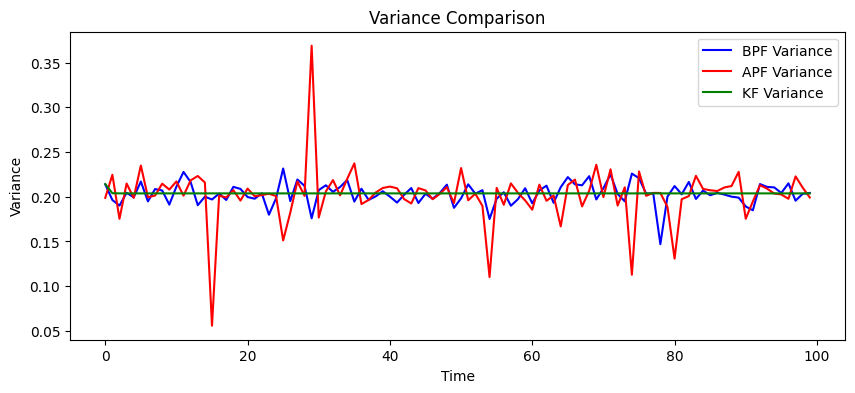

In [16]:
# Plot variances
plt.figure(figsize=(10,4))
plt.plot(bpf_var, label="BPF Variance", color='blue')
plt.plot(apf_var, label="APF Variance", color='red')
plt.plot(kf_var, label="KF Variance", color='green')
plt.xlabel("Time")
plt.ylabel("Variance")
plt.title("Variance Comparison")
plt.legend()
plt.show()